# Recommender Systems, Part 1 (Collaborative Filtering)
- Author: Chris Hodapp
- Date: 2018-03-21

# Table of Contents

- [1. Introduction](#1.-Introduction)
  - [1.1. Motivation](#1.1.-Motivation)
  - [1.2. Organization](#1.2.-Organization)
- [2. Dependencies & Setup](#2.-Dependencies-&-Setup)
- [3. Loading data](#3.-Loading-data)
  - [3.1. Aggregation](#3.1.-Aggregation)
- [4. Utility Matrix](#4.-Utility-Matrix)
- [5. Slope One Predictors](#5.-Slope-One-Predictors)
  - [5.1. Weighted Slope One](#5.1.-Weighted-Slope-One)
  - [5.2. Linear Algebra Tricks](#5.2.-Linear-Algebra-Tricks)
  - [5.3. Implementation](#5.3.-Implementation)
- [6. "SVD" algorithm](#6.-%22SVD%22-algorithm)
  - [6.1. Model & Background](#6.1.-Model-&-Background)
  - [6.2. Motivation](#6.2.-Motivation)
  - [6.3. Prediction & Error Function](#6.3.-Prediction-&-Error-Function)
  - [6.4. Gradients & Gradient Descent Updates](#6.4.-Gradients-&-Gradient-Descent-Updates)
  - [6.5. Implementation](#6.5.-Implementation)
  - [6.6. Running & Testing](#6.6.-Running-&-Testing)
  - [6.7. Visualization of Latent Space](#6.7.-Visualization-of-Latent-Space)
  - [6.8. Bias](#6.8.-Bias)
- [7. Implementations in scikit-surprise](#7.-Implementations-in-scikit-surprise)
- [8. Overall results](#8.-Overall-results)
- [9. Further Work](#9.-Further-Work)

# 1. Introduction

The aim of this notebook is to briefly explain *recommender systems*, show some specific examples of them, and to demonstrate simple implementations of them in Python/NumPy/Pandas.

Recommender systems are quite a broad subject on their own.  This notebook focuses on movie recommendations from explicit ratings. That is, it's focusing on the scenario in which:

- There are a large number of users and a large number of movies.
- Users have supplied ratings on certain movies.
- The movies are different for each user, and the vast majority of users have rated only a tiny fraction of the overall movies.

The goal is to make predictions based on this data, such as:

- How a given user will most likely rate specific movies they have not seen before
- What "new" movies a system might recommended to them

This uses the [MovieLens 20M](https://grouplens.org/datasets/movielens/20m/) dataset, which (as the name suggests) has 20,000,000 movie ratings. You can download it yourself, and probably should if you wish to run the code. Be forewarned that this code runs quite slowly as I've put little effort to optimizing it.

This also focuses on *collaborative filtering*, one basic form of a recommender system. Broadly, this method predicts unknown ratings by using the similarities between users. (This is in contrast to *content-based filtering*, which could work with the similarities between movies based on some properties the MovieLens dataset provides for each movie, such as genre. I'll cover this in another post.)

I refer several times in this notebook to the free textbook [Mining of Massive Datasets](http://www.mmds.org/) (hereafter, just "MMDS"), mostly to chapter 9, *Recommendation Systems*.  It's worth reading if you want to know more.

## 1.1. Motivation

I try to clearly implement everything I talk about here, and be specific about the method. Some other work I read in this area had me rather frustrated with its tendency to completely ignore implementation details that are both critical and very difficult for an outsider (i.e. me) to articulate questions on, and this is something I try to avoid. I'd like for you to be able to execute it yourself, to build intuition on how the math works, to understand why the code implements the math as it does, and to have good starting points for further research.

In the Slope One explanation, this means I give perhaps a needless amount of detail behind the linear algebra implementation, but maybe some will find it valuable (besides just me when I try to read this code in 3 months).

## 1.2. Organization

I start out by loading the movielens data, exploring it briefly, and converting it to a form I need.

Following that, I start with a simple (but surprisingly effective) collaborative filtering model, Slope One Predictors.  I explain it, implement it with some linear algebra shortcuts, and run it on the data.

I go from here to a slightly more complicated method (the badly-named "SVD" algorithm) that is based on matrix completion using matrix decomposition. I explain this, implement it with gradient-descent, and run it on the data. I also use this as an opportunity to visualize a latent feature space that the model learns.

Near the end, I show how to run the same basic algorithms in [scikit-surprise](http://surpriselib.com/) rather than implement them by hand.

# 2. Dependencies & Setup

Download [MovieLens 20M](https://grouplens.org/datasets/movielens/20m/) and uncompress it in the local directory. There should be a `ml-20m` folder.

For Python dependencies, everything I need is imported below: pandas, numpy, matplotlib, and scikit-learn.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.model_selection

# 3. Loading data

I don't explain this in detail. This is just standard calls in [Pandas](https://pandas.pydata.org/) and little details that are boring but essential:

In [2]:
ml = pd.read_csv("ml-20m/ratings.csv",
                 header=0,
                 dtype={"user_id": np.int32, "movie_id": np.int32, "rating": np.float32, "time": np.int64},
                 names=("user_id", "movie_id", "rating", "time"))
# Convert Unix seconds to a Pandas timestamp:
ml["time"] = pd.to_datetime(ml["time"], unit="s")

Below is just to inspect that data appears to be okay:

In [3]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
user_id     int32
movie_id    int32
rating      float32
time        datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int32(2)
memory usage: 381.5 MB


In [4]:
ml.describe()

,user_id,movie_id,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.494030e+00
std,4.003863e+04,1.978948e+04,9.998490e-01
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [5]:
ml[:10]

,user_id,movie_id,rating,time
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
5,1,112,3.5,2004-09-10 03:09:00
6,1,151,4.0,2004-09-10 03:08:54
7,1,223,4.0,2005-04-02 23:46:13
8,1,253,4.0,2005-04-02 23:35:40
9,1,260,4.0,2005-04-02 23:33:46


In [6]:
max_user  = int(ml["user_id"].max() + 1)
max_movie = int(ml["movie_id"].max() + 1)
max_user, max_movie, max_user * max_movie

(138494, 131263, 18179137922)

Computing what percent we have of all 'possible' ratings (i.e. every single movie & every single user), this data is rather sparse:

In [7]:
print("%.2f%%" % (100 * ml.shape[0] / (max_user * max_movie)))

0.11%


## 3.1. Aggregation

This is partly just to explore the data a little, and partly because we need to aggregate some information to use in models later - like the number of ratings for each movie, and each movie's average rating.

The dataset includes a lot of per-movie information too, but we only bother with the title so far:

In [8]:
names = pd.read_csv(
    "ml-20m/movies.csv", header=0,
    encoding = "ISO-8859-1", index_col=0,
    names=("movie_id", "movie_title"), usecols=[0,1])

In [9]:
movie_group = ml.groupby("movie_id")
movie_stats = names.\
    join(movie_group.size().rename("num_ratings")).\
    join(movie_group.mean()["rating"].rename("avg_rating"))

Sorting by number of ratings and taking the top 25, this looks pretty sensible:

In [10]:
movie_stats.sort_values("num_ratings", ascending=False)[:25]

,movie_title,num_ratings,avg_rating
movie_id,,,
296,Pulp Fiction (1994),67310.0,4.174231
356,Forrest Gump (1994),66172.0,4.029000
318,"Shawshank Redemption, The (1994)",63366.0,4.446990
593,"Silence of the Lambs, The (1991)",63299.0,4.177056
480,Jurassic Park (1993),59715.0,3.664741
260,Star Wars: Episode IV - A New Hope (1977),54502.0,4.190672
110,Braveheart (1995),53769.0,4.042534
589,Terminator 2: Judgment Day (1991),52244.0,3.931954
2571,"Matrix, The (1999)",51334.0,4.187186


Prior to anything else, split training/test data out with a specific random seed:

In [11]:
ml_train, ml_test = sklearn.model_selection.train_test_split(ml, test_size=0.25, random_state=12345678)

# 4. Utility Matrix

The notion of the *utility matrix* comes up in many methods as a way of
expressing the ratings data. For one thing, this opens up the data to an
array of linear algebra operations (such as matrix multiplication and
[SVD](https://en.wikipedia.org/wiki/Singular-value_decomposition)) that
are useful for transforming the data, meaningful for interpreting it,
very readily-available and optimized, and provide a common language for
discussing and analyzing what we are actually doing to the data.  (For some
examples of this, check out section 11.3.2 in [MMDS](http://www.mmds.org/).)

In a utility matrix, each row represents one user, each column represents
one item (a movie, in our case), and each element represents a user's
rating of an item.  If we have $n$ users and $m$ movies, then this is a
$n \times m$ matrix $U$ for which $U_{k,i}$ is user $k$'s rating for
movie $i$ - assuming we've numbered our users and our movies.

Users have typically rated only a fraction of movies, and so most of
the elements of this matrix are unknown. Algorithms represent this
in different ways; the use of [sparse matrices](https://en.wikipedia.org/wiki/Sparse_matrix)
where a value of 0 signifies unknown information is common.

Some algorithms involve constructing the utility matrix explicitly and
doing matrix operations directly on it. The approach to Slope One that
we do later works somewhat this way. Other methods just use it as a method of
analyzing something from a linear algebra standpoint, but dispense with
the need for an explicit matrix within the algorithm. The "SVD" method
later does this.

We'll convert to a utility matrix, for which the naive way is creating a dense matrix:

```python
m = np.zeros((max_user, max_movie))
m[df["user_id"], df["movie_id"]] = df["rating"]
```

...but we'd be dealing with a 18,179,137,922-element matrix that's a little bit unusable here (at least it is for me since I only have 32 GB RAM), so we'll use [sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html).

In [12]:
def df2mat(df):
    m = scipy.sparse.coo_matrix(
        (df["rating"], (df["user_id"], df["movie_id"])),
        shape=(max_user, max_movie),
        dtype=np.float32).tocsc()
    return m, m > 0

ml_mat_train, ml_mask_train = df2mat(ml_train)
ml_mat_test,  ml_mask_test  = df2mat(ml_test)

We need a mask for some later steps, hence the m > 0 step. Ratings go only from 1 to 5, so values of 0 are automatically unknown/missing data, which fits with how sparse matrices work.

In [13]:
ml_mat_train

<138494x131263 sparse matrix of type '<class 'numpy.float32'>'
	with 15000197 stored elements in Compressed Sparse Column format>

To demonstrate that the matrix and dataframe have the same data:

In [14]:
ml_train[:10]

,user_id,movie_id,rating,time
13746918,94976,7371,4.5,2009-11-04 05:51:26
15855529,109701,1968,3.0,2002-04-08 06:04:50
1479530,10017,2248,3.0,2014-09-11 12:05:12
16438705,113806,1210,4.5,2005-04-24 19:15:31
17014834,117701,4223,4.0,2001-07-18 07:45:15
2626824,17818,7325,2.5,2008-10-29 14:49:13
10604986,73349,29,5.0,2000-10-25 20:55:56
15311014,105846,4226,4.5,2004-07-30 18:12:26
8514776,58812,1285,4.0,2000-04-24 20:39:46
3802643,25919,3275,2.5,2010-06-18 00:48:40


In [15]:
list(ml_train.iloc[:10].rating)

[4.5, 3.0, 3.0, 4.5, 4.0, 2.5, 5.0, 4.5, 4.0, 2.5]

In [16]:
user_ids = list(ml_train.iloc[:10].user_id)
movie_ids = list(ml_train.iloc[:10].movie_id)
[ml_mat_train[u,i] for u,i in zip(user_ids, movie_ids)]

[4.5, 3.0, 3.0, 4.5, 4.0, 2.5, 5.0, 4.5, 4.0, 2.5]

Okay, enough of that; we can begin with some actual predictions.

# 5. Slope One Predictors

We'll begin with a method of predicting ratings that is wonderfully
simple to understand, equally simple to implement, very fast,
and surprisingly effective.  This method is described in the
paper [Slope One Predictors for Online Rating-Based Collaborative Filtering](https://arxiv.org/pdf/cs/0702144v1.pdf). They can be computed given
just some arithmetic over the dataset we just loaded.
Neither linear algebra nor calculus nor numerical
approximation is needed, while all three are needed for the
[next method](#"SVD"-algorithm).

I'll give a contrived example below to explain them.

Consider a user Bob.  Bob is enthusiastic, but has rather simple
tastes: he mostly just watches Clint Eastwood movies.  In fact, he's
watched and rated nearly all of them, and basically nothing else.

Now, suppose we want to predict how much Bob will like something
completely different and unheard of (to him at least), like... I don't
know... *Citizen Kane*.

Here's Slope One in a nutshell:

1. First, find the users who rated both *Citizen Kane* and any of
   the Clint Eastwood movies that Bob rated.
2. Now, for each movie that comes up above, compute a _deviation_
   which tells us: On average, how differently (i.e. how much higher
   or lower) did those users rate Citizen Kane compared to this movie?  (For
   instance, we'll have a number for how *Citizen Kane* was rated
   compared to *Dirty Harry*, and perhaps it's +0.6 - meaning that on
   average, users who rated both movies rated *Citizen Kane* about 0.6
   stars above *Dirty Harry*.  We'd have another deviation for
   *Citizen Kane* compared to *Gran Torino*, another for *Citizen
   Kane* compared to *The Good, the Bad and the Ugly*, and so on - for
   every movie that Bob rated, provided that other users who rated
   *Citizen Kane* also rated the movie.)
3. If that deviation between *Citizen Kane* and *Dirty Harry* was
   +0.6, it's reasonable that adding 0.6 from Bob's rating on *Dirty
   Harry* would give one prediction of how Bob might rate *Citizen
   Kane*.  We can then generate more predictions based on the ratings
   he gave the other movies - anything for which we could compute a
   deviation.
4. To turn this to a single prediction, we could just average all
   those predictions together.

Note carefully that step 2 is _not_ asking for a difference in average
ratings across all users. It is asking for an average of differences in
ratings across a specific set of users.

Now, I'm not sure that Bob is an actual user in this dataset, but I
will go through these steps with some real data. I arbitrarily chose
user 28812:

In [17]:
pd.set_option('display.max_rows', 10)

In [18]:
target_user = 28812
names.merge(ml_train[ml_train.user_id == target_user], right_on="movie_id", left_index=True)

,movie_title,user_id,movie_id,rating,time
4229884,Jumanji (1995),28812,2,5.0,1996-09-23 02:08:39
4229885,Heat (1995),28812,6,4.0,1996-09-23 02:11:00
4229886,GoldenEye (1995),28812,10,5.0,1996-09-23 02:03:57
4229887,Ace Ventura: When Nature Calls (1995),28812,19,4.0,1996-09-23 02:05:59
4229888,Get Shorty (1995),28812,21,5.0,1996-09-23 02:05:59
...,...,...,...,...,...
4229953,Beauty and the Beast (1991),28812,595,4.0,1996-09-23 02:03:07
4229954,Pretty Woman (1990),28812,597,5.0,1996-09-23 02:06:22
4229957,Independence Day (a.k.a. ID4) (1996),28812,780,5.0,1996-09-23 02:09:02
4229959,Phenomenon (1996),28812,802,5.0,1996-09-23 02:09:02


I picked *Home Alone*, movie ID 586, as the one we want to predict user 28812's rating on. This isn't completely arbitrary. I chose it because the testing data contains the actual rating and we can compare against it later.

In [19]:
target_movie = 586
names[names.index == target_movie]

,movie_title
movie_id,
586,Home Alone (1990)


Now, from step #1 and about half of step #2: What users also rated one of the movies that 28812 rated, *and* rated *Home Alone*?  What were those ratings?

In [20]:
users_df = ml_train[ml_train.user_id == target_user][["movie_id"]]. \
    merge(ml_train, on="movie_id")[["movie_id", "user_id", "rating"]]. \
    merge(ml_train[ml_train.movie_id == target_movie], on="user_id"). \
    drop(["movie_id_y", "time"], axis=1)
# time is irrelevant to us, movie_id_y is just always 3175
users_df

,movie_id_x,user_id,rating_x,rating_y
0,329,17593,3.0,4.0
1,480,17593,4.0,4.0
2,588,17593,4.0,4.0
3,454,17593,4.0,4.0
4,457,17593,5.0,4.0
...,...,...,...,...
522686,296,60765,5.0,5.0
522687,2,90366,3.0,3.0
522688,2,126271,3.0,4.0
522689,595,82760,2.0,4.0


Each row has one user's ratings of both *Home Alone* (it's the `rating_y` column), and some other movie that 28812 rated (`rating_x`), so we can easily find the deviation of each individual rating - how much higher they rated *Home Alone* than the respective movie for `movie_id_x`:

In [21]:
users_df = users_df.assign(rating_dev = users_df.rating_y - users_df.rating_x)
users_df

,movie_id_x,user_id,rating_x,rating_y,rating_dev
0,329,17593,3.0,4.0,1.0
1,480,17593,4.0,4.0,0.0
2,588,17593,4.0,4.0,0.0
3,454,17593,4.0,4.0,0.0
4,457,17593,5.0,4.0,-1.0
...,...,...,...,...,...
522686,296,60765,5.0,5.0,0.0
522687,2,90366,3.0,3.0,0.0
522688,2,126271,3.0,4.0,1.0
522689,595,82760,2.0,4.0,2.0


...and for the rest of step 2, turn this to an average deviation by grouping by movie ID. For the sake of displaying it, inner join with the dataframe that has movie titles:

In [22]:
pd.set_option('display.max_rows', 20)
rating_dev = users_df.groupby("movie_id_x").mean()["rating_dev"]
names.join(rating_dev, how="inner").sort_values("rating_dev")

,movie_title,rating_dev
318,"Shawshank Redemption, The (1994)",-1.391784
50,"Usual Suspects, The (1995)",-1.316480
527,Schindler's List (1993),-1.283499
296,Pulp Fiction (1994),-1.116245
593,"Silence of the Lambs, The (1991)",-1.114274
32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),-0.953710
356,Forrest Gump (1994),-0.946414
110,Braveheart (1995),-0.941996
457,"Fugitive, The (1993)",-0.876993
1036,Die Hard (1988),-0.871772


The numbers above then tell us that, on average, users who watched both movies rated *Home Alone* about 1.4 below *Shawshank Redemption*; likewise, 1.3 below *Usual Suspects*, and so on, up to 0.53 above *Ace Ventura: When Nature Calls* and 0.56 above *Congo*. This fits with what we might expect (setting aside any strong opinions people have about Home Alone or about Jim Carrey's acting).

For step 3, we can produce a prediction from each deviation above by adding it to each of user 28812's ratings for the respective movies:

In [23]:
df = ml_train[ml_train.user_id == target_user]. \
    join(rating_dev, on="movie_id")
df = df.assign(rating_adj = df["rating"] + df["rating_dev"])[["user_id", "movie_id", "rating", "rating_adj"]]
df.join(names, on="movie_id").sort_values("movie_title")

,user_id,movie_id,rating,rating_adj,movie_title
4229920,28812,344,3.0,3.141987,Ace Ventura: Pet Detective (1994)
4229887,28812,19,4.0,4.530155,Ace Ventura: When Nature Calls (1995)
4229930,28812,410,4.0,4.127372,Addams Family Values (1993)
4229948,28812,588,4.0,3.470915,Aladdin (1992)
4229895,28812,150,5.0,4.254292,Apollo 13 (1995)
4229890,28812,34,4.0,3.588504,Babe (1995)
4229951,28812,592,4.0,3.657092,Batman (1989)
4229897,28812,153,4.0,4.218620,Batman Forever (1995)
4229953,28812,595,4.0,3.515051,Beauty and the Beast (1991)
4229931,28812,420,5.0,5.382058,Beverly Hills Cop III (1994)


That is, every 'adjusted' rating above (the `rating_adj` column) is something like: based on just this movie, what rating would we expect user 28812 to give *Home Alone*? Produce the final prediction by averaging all these:

In [24]:
df["rating_adj"].mean()

4.087520122528076

As mentioned above, we also happen to have the user's actual rating on *Home Alone* in the test set (i.e. we didn't train on it), so we can compare here:

In [25]:
ml_test[(ml_test.user_id == target_user) & (ml_test.movie_id == target_movie)]["rating"].iloc[0]

4.0

That's quite close - though that may just be luck. It's hard to say from one point.

## 5.1. Weighted Slope One

Take a look at the table below. This is a similar aggregation to what we just did to determine average deviation - but this instead counts up the number of ratings that went into each average deviation.

In [26]:
num_ratings = users_df.groupby("movie_id_x").count()["rating_dev"].rename("num_ratings")
names.join(num_ratings, how="inner").sort_values("num_ratings")

,movie_title,num_ratings
802,Phenomenon (1996),3147
315,"Specialist, The (1994)",3247
282,Nell (1994),3257
151,Rob Roy (1995),3351
236,French Kiss (1995),3645
432,City Slickers II: The Legend of Curly's Gold (...,4054
553,Tombstone (1993),4241
173,Judge Dredd (1995),4308
160,Congo (1995),4472
420,Beverly Hills Cop III (1994),4693


We produced an overall average prediction by averaging together
all of the average deviations produced from the above ratings.
This has a potential problem that can occur. Look at the table
above, and note that *Forrest Gump* has around four times as many
ratings as *Phenomenon*, yet both movies receive the same total
number of votes (so to speak).

This isn't as drastic of an example as possible, but we might like
to adjust things so that the amount of weight that's given to each
average deviation depends on how many ratings are in it; presumably,
the more ratings that go into that average deviation, the better of
an estimate it is.

This is easy to do, luckily:

In [27]:
df = df.join(num_ratings, on="movie_id")
df = df.assign(rating_weighted = df["rating_adj"] * df["num_ratings"])
df

,user_id,movie_id,rating,rating_adj,num_ratings,rating_weighted
4229918,28812,329,4.0,3.767164,6365,23978.000326
4229939,28812,480,5.0,4.400487,13546,59609.002631
4229948,28812,588,4.0,3.470915,10366,35979.500767
4229899,28812,161,4.0,3.415830,5774,19723.000448
4229914,28812,315,5.0,5.276409,3247,17132.500507
4229936,28812,454,5.0,4.638914,7663,35547.998812
4229937,28812,457,5.0,4.123007,10853,44746.998200
4229923,28812,356,5.0,4.053586,13847,56129.998825
4229944,28812,539,5.0,4.621340,9325,43093.998063
4229894,28812,141,5.0,4.611132,5390,24853.999691


In [28]:
df["rating_weighted"].sum() / df["num_ratings"].sum()

4.02968199025023

It changes the answer, but only very slightly.

## 5.2. Linear Algebra Tricks

I said linear algebra isn't needed, which is true.  Everything above
was implemented just in operations over Pandas dataframes, albeit
with a lot of merges and joins, and it's probably not very efficient.
Someone adept in SQL could probably implement this directly over
some database tables in a few queries.

However, the entire Slope One method can be implemented in a faster
and concise way with a couple matrix operations. If matrices make your
eyes glaze over, you can probably just skip this section.

### 5.2.1. Short Answer

Let $U$ be the utility matrix. Let $M$ be a binary matrix for which $M_{i,j}=1$ if user $i$ rated movie $j$, otherwise 0.  Compute the model's matrices with:

$$
\begin{align}
C & =M^\top M \\
D &= \left(M^\top U - (M^\top U)^\top\right) /\ \textrm{max}(1, M^\top M)
\end{align}
$$

where $/$ is Hadamard (i.e. elementwise) division, and $\textrm{max}$ is elementwise maximum with 1.  Then, the below gives the prediction for how user $u$ will rate movie $j$:

$$
P(u)_j = \frac{[M_u \odot (C_j > 0)] \cdot (D_j + U_u) - U_{u,j}}{M_u \cdot (C_j > 0)}
$$

$D_j$ and $C_j$ are row $j$ of $D$ and $C$, respectively. $M_u$ and $U_u$ are column $u$ of $M$ and $U$, respectively. $\odot$ is elementwise multiplication.

### 5.2.2. Long Answer

First, we need to have our data encoded as an $n \times m$ utility
matrix (see a [few sections above](#Utility-Matrix) for the definition
of *utility matrix*).
As noted, most elements of this matrix are unknown as users have rated
only a fraction of movies. We can represent this with another
$n \times m$ matrix (specifically a binary matrix), a 'mask' $M$ in
which $M_{k,i}$ is 1 if user $k$ supplied a rating for movie $i$, and
otherwise 0.

#### 5.2.2.1. Deviation Matrix

I mentioned *deviation* above and gave an informal definition of it.
The paper gaves a formal but rather terse definition below of the
average deviation of item $i$ with respect to item $j$, and I
then separate out the summation a little:

$$
\begin{split}
\textrm{dev}_{j,i} &= \sum_{u \in S_{j,i}(\chi)} \frac{u_j - u_i}{card(S_{j,i}(\chi))} \\
 &= \frac{1}{card(S_{j,i}(\chi))} \sum_{u \in
S_{j,i}(\chi)} u_j - u_i = \frac{1}{card(S_{j,i}(\chi))}\left(\sum_{u
\in S_{j,i}(\chi)} u_j - \sum_{u \in S_{j,i}(\chi)} u_i\right)
\end{split}
$$

where:

- $u_j$ and $u_i$ mean: user $u$'s ratings for movies $i$ and $j$, respectively
- $u \in S_{j,i}(\chi)$ means: all users $u$ who, in the dataset we're
  training on, provided a rating for both movie $i$ and movie $j$
- $card$ is the cardinality of that set, i.e.
  ${card(S_{j,i}(\chi))}$ is how many users rated both $i$ and
  $j$.

#### 5.2.2.2. Cardinality/Counts Matrix

Let's start with computing ${card(S_{j,i}(\chi))}$, the number of
users who rated both movie $i$ and movie $j$.  Consider column $i$ of
the mask $M$.  For each value in this column, it equals 1 if the
respective user rated movie $i$, or 0 if they did not.  Clearly,
simply summing up column $i$ would tell us how many users rated movie
$i$, and the same applies to column $j$ for movie $j$.

Now, suppose we take element-wise logical AND of columns $i$ and $j$.
The resultant column has a 1 only where both corresponding elements
were 1 - where a user rated both $i$ and $j$.  If we sum up this
column, we have exactly the number we need: the number of users who
rated both $i$ and $j$. Some might notice that "elementwise logical
AND" is just "elementwise
multiplication", thus "sum of elementwise logical AND" is just "sum of
elementwise multiplication", which is: dot product.  That is,
${card(S_{j,i}(\chi))}=M_j \cdot M_i$ if we use $M_i$ and $M_j$ for
columns $i$ and $j$ of $M$.

However, we'd like to compute deviation as a matrix for all $i$ and
$j$, so we'll likewise need ${card(S_{j,i}(\chi))}$ for every single
combination of $i$ and $j$ - that is, we need a dot product between
every single pair of columns from $M$.  This is incidentally just
matrix multiplication:

$$C=M^\top M$$

since $C_{i,j}=card(S_{j,i}(\chi))$ is the dot product of row $i$ of $M^T$ - which is column
$i$ of $M$ - and column $j$ of $M$.

That was the first half of what we needed for $\textrm{dev}_{j,i}$.
We still need the other half:

$$\sum_{u \in S_{j,i}(\chi)} u_j - \sum_{u \in S_{j,i}(\chi)} u_i$$

We can apply a similar trick here.  Consider first what $\sum_{u \in
S_{j,i}(\chi)} u_j$ means: It is the sum of only those ratings of
movie $j$ that were done by a user who also rated movie $i$.
Likewise, $\sum_{u \in S_{j,i}(\chi)} u_i$ is the sum of only those
ratings of movie $i$ that were done by a user who also rated movie
$j$.  (Note the symmetry: it's over the same set of users, because
it's always the users who rated both $i$ and $j$.)

Let's call the utility matrix $U$, and use $U_i$ and $U_j$ to refer
to columns $i$ and $j$ of it (just as in $M$).  $U_i$ has each rating
of movie $i$, but we want only the sum of the ratings done by a user
who also rated movie $j$. Like before, the dot product of $U_i$ and
$M_j$ (consider the definition of $M_j$) computes this, and so:

$$\sum_{u \in S_{j,i}(\chi)} u_j = M_i \cdot U_j$$

and as with $C$, since we want every pairwise dot product, this summation just
equals element $(i,j)$ of $M^\top U$. The other half of the summation,
$\sum_{u \in S_{j,i}(\chi)} u_i$, equals $M_j \cdot U_i$, which is just
the transpose of this matrix:

$$\sum_{u \in S_{j,i}(\chi)} u_j - \sum_{u \in S_{j,i}(\chi)} u_i = M^\top U - (M^\top U)^\top = M^\top U - U^\top M$$

So, finally, we can compute an entire deviation matrix at once like:

$$D = \left(M^\top U - (M^\top U)^\top\right) /\ M^\top M$$

where $/$ is Hadamard (i.e. elementwise) division, and $D_{j,i} = \textrm{dev}_{j,i}$.

By convention and to avoid division by zero, we treat the case where the denominator and numerator are both 0 as just equaling 0. This comes up only where no ratings exist for there to be a deviation - hence the `np.maximum(1, counts)` below.

#### 5.2.2.3. Prediction

Finally, the paper gives the formula to predict how user $u$ will rate movie $j$, and I write this in terms of our matrices:

$$
P(u)_j = \frac{1}{card(R_j)}\sum_{i\in R_j} \left(\textrm{dev}_{j,i}+u_i\right) = \frac{1}{card(R_j)}\sum_{i\in R_j} \left(D_{j,i} + U_{u,j} \right)
$$

where $R_j = \{i | i \in S(u), i \ne j, card(S_{j,i}(\chi)) > 0\}$, and $S(u)$ is the set of movies that user $u$ has rated. To unpack the paper's somewhat dense notation, the summation is over every movie $i$ that user $u$ rated and that at least one other user rated, except movie $j$.

We can apply the usual trick yet one more time with a little effort. The summation already goes across a row of $U$ and $D$ (that is, user $u$ is held constant), but covers only certain elements. This is equivalent to a dot product with a mask representing $R_j$. $M_u$, row $u$ of the mask, already represents $S(u)$, and $R_j$ is just $S(u)$ with some more elements removed - which we can mostly represent with $M_u \odot (C_j > 0)$ where $\odot$ is elementwise product (i.e. Hadamard), $C_j$ is column/row $j$ of $C$ (it's symmetric), and where we abuse some notation to say that $C_j > 0$ is a binary vector.  Likewise, $D_j$ is row $j$ of $D$. The one correction still required is that we subtract $u_j$ to cover for the $i \ne j$ part of $R_j$.  To abuse some more notation:

$$P(u)_j = \frac{[M_u \odot (C_j > 0)] \cdot (D_j + U_u) - U_{u,j}}{M_u \cdot (C_j > 0)}$$

#### 5.2.2.4. Approximation

The paper also gives a formula that is a suitable approximation for larger data sets:

$$p^{S1}(u)_j = \bar{u} + \frac{1}{card(R_j)}\sum_{i\in R_j} \textrm{dev}_{j,i}$$

where $\bar{u}$ is user $u$'s average rating. This doesn't change the formula much; we can compute $\bar{u}$ simply as column means of $U$.

## 5.3. Implementation

I left out another detail above, which is that the above can't really be implemented exactly as written on this dataset (though, it works fine for the much smaller [ml-100k](https://grouplens.org/datasets/movielens/100k/)) because it uses entirely too much memory.

While $U$ and $M$ can be sparse matrices, $C$ and $D$ sort of must be dense matrices, and for this particular dataset they are a bit too large to work with in memory in this form. Some judicious optimization, attention to datatypes, use of $C$ and $D$ being symmetric and skew-symmetric respectively, and care to avoid extra copies could probably work around this - but I don't do that here.

However, if we look at the $P(u)_j$ formula above, it refers only to row $j$ of $C$ and $D$ and the formulas for $C$ and $D$ make it easy to compute them by row if needed, or by blocks of rows according to what $u$ and $j$ we need. This is what I do below.

In [29]:
def slope_one(U, M, users, movies, approx=True):
    M_j = M[:,movies].T.multiply(1)
    U_j = U[:,movies].T
    Cj = M_j.dot(M).toarray()
    MjU = M_j.dot(U).toarray()
    UjM = U_j.dot(M).toarray()
    Dj = (UjM - MjU) / np.maximum(Cj, 1)
    mask = M[users,:].toarray() * (Cj > 0)
    U_u = U[users,:].toarray()
    if approx:
        M_u = M[users,:].toarray()
        P_u_j = U_u.sum(axis=1) / M_u.sum(axis=1) + ((mask * Dj).sum(axis=1) - U_u[0,movies]) / np.maximum(mask.sum(axis=1), 1)
    else:
        P_u_j = ((mask * (U_u + Dj)).sum(axis=1) - U_u[0,movies]) / np.maximum(mask.sum(axis=1), 1)
    return P_u_j

To show that it actually gives the same result as above, and that the approximation produces seemingly no change here:

In [30]:
(slope_one(ml_mat_train, ml_mask_train, [target_user], [target_movie])[0],
 slope_one(ml_mat_train, ml_mask_train, [target_user], [target_movie], approx=False)[0])

(4.0875210502743862, 4.0875210502743862)

This computes training error on a small part (1%) of the data, since doing it over the entire thing would be horrendously slow:

In [31]:
def slope_one_err(U, M, users, movies, true_ratings):
    # Keep 'users' and 'movies' small (couple hundred maybe)
    p = slope_one(U, M, users, movies)
    d = p - true_ratings
    err_abs = np.abs(d).sum()
    err_sq = np.square(d).sum()
    return err_abs, err_sq

In [32]:
import multiprocessing

count = int(len(ml_train) * 0.01)
idxs = np.random.permutation(len(ml_train))[:count]
# Memory increases linearly with chunk_size:
chunk_size = 200
idxs_split = np.array_split(idxs, count // chunk_size)

def err_part(idxs_part):
    df = ml_train.iloc[idxs_part]
    users = list(df.user_id)
    movies = list(df.movie_id)
    true_ratings = np.array(df.rating)
    err_abs, err_sq = slope_one_err(ml_mat_train, ml_mask_train, users, movies, true_ratings)
    return err_abs, err_sq

with multiprocessing.Pool() as p:
    errs = p.map(err_part, idxs_split)
    err_mae_train = sum([e[0] for e in errs]) / count
    err_rms_train = np.sqrt(sum([e[1] for e in errs]) / count)

and then likewise on 2% of the testing data (it's a smaller set to start):

In [33]:
import multiprocessing

count = int(len(ml_test) * 0.02)
idxs = np.random.permutation(len(ml_test))[:count]
chunk_size = 200
idxs_split = np.array_split(idxs, count // chunk_size)

def err_part(idxs_part):
    df = ml_test.iloc[idxs_part]
    users = list(df.user_id)
    movies = list(df.movie_id)
    true_ratings = np.array(df.rating)
    err_abs, err_sq = slope_one_err(ml_mat_train, ml_mask_train, users, movies, true_ratings)
    return err_abs, err_sq

with multiprocessing.Pool() as p:
    errs = p.map(err_part, idxs_split)
    err_mae_test = sum([e[0] for e in errs]) / count
    err_rms_test = np.sqrt(sum([e[1] for e in errs]) / count)

In [34]:
# These are used later for comparison:
test_results = [("", "Slope One", err_mae_test, err_rms_test)]

In [35]:
print("Training error: MAE={:.3f},  RMSE={:.3f}".format(err_mae_train, err_rms_train))
print("Testing error:  MAE={:.3f},  RMSE={:.3f}".format(err_mae_test, err_rms_test))

Training error: MAE=0.640,  RMSE=0.834
Testing error:  MAE=0.657,  RMSE=0.856


# 6. "SVD" algorithm

## 6.1. Model & Background

This basic model is very easy to implement, but the implementation won't make sense without some more involved derivation.

I'm not sure this method has a clear name. Surprise calls it an SVD algorithm, but it neither uses SVD nor really computes it; it's just vaguely SVD-like. To confuse matters further, several other algorithms compute similar things and do use SVD, but are completely unrelated.

References on this model are in a few different places:

- [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) in Surprise gives enough formulas to implement from.
- Simon Funk's post [Netflix Update: Try This at Home](http://sifter.org/~simon/journal/20061211.html) is an excellent overview of the rationale and of some practical concerns on how to run this on the much larger Netflix dataset (100,000,000 ratings, instead of 100,000).
- The paywalled article [Matrix Factorization Techniques for Recommender Systems](http://ieeexplore.ieee.org/abstract/document/5197422/) gives a little background from a higher level.

## 6.2. Motivation

We again start from the $n \times m$ utility matrix $U$.  As $m$ and $n$ tend to be quite large, $U$ has a lot of degrees of freedom.  If we want to be able to predict anything at all, we must assume some fairly strict constraints - and one form of this is assuming that we don't *really* have that many degrees of freedom, and that there are actually some much smaller latent factors controlling everything.

One common form of this is assuming that the rank of matrix $U$ - its *actual* dimensionality - is much lower. Let's say its rank is $r$.  We could then represent $U$ as the matrix product of smaller matrices, i.e. $U=P^\top Q$ where $P$ is a $r \times n$ matrix and $Q$ is $r \times m$.

If we can find dense matrices $P$ and $Q$ such that $P^\top Q$ equals, or approximately equals, $U$ for the corresponding elements of $U$ that are known, then $P^\top Q$ also gives us predictions for the unknown elements of $U$ - the ratings we don't know, but want to predict.  Of course, $r$ must be small enough here to prevent overfitting.

(What we're talking about above is [matrix completion](https://en.wikipedia.org/wiki/Matrix_completion) using low-rank [matrix decomposition/factorization](https://en.wikipedia.org/wiki/Matrix_decomposition). These are both subjects unto themselves. See the [matrix-completion-whirlwind](https://github.com/asberk/matrix-completion-whirlwind/blob/master/matrix_completion_master.ipynb) notebook for a much better explanation on that subject, and an implementation of [altMinSense/altMinComplete](https://arxiv.org/pdf/1212.0467).)

Ordinarily, we'd use something like SVD directly if we wanted to find matrices $P$ and $Q$ (or if we wanted to do any of about 15,000 other things, since SVD is basically magical matrix fairy dust). We can't really do that here due to the fact that large parts of $U$ are unknown, and in some cases because $U$ is just too large.  One approach for working around this is the UV-decomposition algorithm that section 9.4 of [MMDS](http://www.mmds.org/) describes.

What we'll do below is a similar approach to UV decomposition that follows a common method: define a model, define an error function we want to minimize, find that error function's gradient with respect to the model's parameters, and then use gradient-descent to minimize that error function by nudging the parameters in the direction that decreases the error, i.e. the negative of their gradient.  (More on this later.)

Matrices $Q$ and $P$ have some other neat properties too. Note that $Q$ has $m$ columns, each one $r$-dimensional - one column per movie.  $P$ has $n$ columns, each one $r$-dimensional - one column per user. In effect, we can look at each column $i$ of $Q$ as the coordinates of movie $i$ in "concept space" or "feature space" - a new $r$-dimensional space where each axis corresponds to something that seems to explain ratings. Likewise, we can look at each column $u$ of $P$ as how much user $u$ "belongs" to each axis in concept space.  "Feature vectors" is a common term to see.

In that sense, $P$ and $Q$ give us a model in which ratings are an interaction between properties of a movie, and a user's preferences.  If we're using $U=P^\top Q$ as our model, then every element of $U$ is just the dot product of the feature vectors of the respective movie and user.  That is, if $p_u$ is column $u$ of $P$ and $q_i$ is column $i$ of $Q$:

$$\hat{r}_{ui}=q_i^\top p_u$$

However, some things aren't really interactions. Some movies are just (per the ratings) overall better or worse. Some users just tend to rate everything higher or lower. We need some sort of bias built into the model to comprehend this.

Let's call $b_i$ the bias for movie $i$, $b_u$ the bias for user $u$, and $\mu$ the overall average rating. We can just add these into the model:

$$\hat{r}_{ui}=\mu + b_i + b_u + q_i^\top p_u$$

This is the basic model we'll implement, and the same one described in the references at the top.

## 6.3. Prediction & Error Function

More formally, the prediction model is:

$$\hat{r}_{ui}=\mu + b_i + b_u + q_i^\top p_u$$

where:

- $u$ is a user
- $i$ is an item
- $\hat{r}_{ui}$ is user $u$'s predicted rating for item $i$
- $\mu$ is the overall average rating
- our model parameters are:
  - $b_i$, a per-item deviation for item $i$; 
  - $b_u$, per-user deviation for user $u$
  - $q_i$ and $p_u$, feature vectors for item $i$ and user $u$, respectively

The error function that we need to minimize is just sum-of-squared error between predicted and actual rating, plus $L_2$ regularization to prevent the biases and coordinates in "concept space" from becoming too huge:
$$E=\sum_{r_{ui} \in R_{\textrm{train}}} \left(r_{ui} - \hat{r}_{ui}\right)^2 + \lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right)$$

## 6.4. Gradients & Gradient-Descent Updates

This error function is easily differentiable with respect to model parameters $b_i$, $b_u$, $q_i$, and $p_u$, so a normal approach for minimizing it is gradient-descent.  Finding gradient with respect to $b_i$ is straightforward:

$$
\begin{split}
\frac{\partial E}{\partial b_i} &= \sum_{r_{ui}} \frac{\partial}{\partial b_i} \left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)^2 + \frac{\partial}{\partial b_i}\lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right) \\
\frac{\partial E}{\partial b_i} &= \sum_{r_{ui}} 2\left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)(-1) + 2 \lambda b_i \\
\frac{\partial E}{\partial b_i} &= 2 \sum_{r_{ui}} \left(\lambda b_i + r_{ui} - \hat{r}_{ui}\right)
\end{split}
$$

Gradient with respect to $p_u$ proceeds similarly:

$$
\begin{split}
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} \frac{\partial}{\partial p_u} \left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)^2 + \frac{\partial}{\partial p_u}\lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right) \\
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} 2\left(r_{ui} - \hat{r}_{ui}\right)\left(-\frac{\partial}{\partial
p_u}q_i^\top p_u \right) + 2 \lambda p_u \\
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} 2\left(r_{ui} - \hat{r}_{ui}\right)(-q_i^\top) + 2 \lambda p_u \\
\frac{\partial E}{\partial p_u} &= 2 \sum_{r_{ui}} \lambda p_u - \left(r_{ui} - \hat{r}_{ui}\right)q_i^\top
\end{split}
$$

Gradient with respect to $b_u$ is identical form to $b_i$, and gradient with respect to $q_i$ is identical form to $p_u$, except that the variables switch places.  The full gradients then have the standard form for gradient descent, i.e. a summation of a gradient term for each individual data point, so they turn easily into update rules for each parameter (which match the ones in the Surprise link) after absorbing the leading 2 into learning rate $\gamma$ and separating out the summation over each data point. That's given below, with $e_{ui}=r_{ui} - \hat{r}_{ui}$:

$$
\begin{split}
\frac{\partial E}{\partial b_i} &= 2 \sum_{r_{ui}} \left(\lambda b_i + e_{ui}\right)\ \ \ &\longrightarrow b_i' &= b_i - \gamma\frac{\partial E}{\partial b_i} &= b_i + \gamma\left(e_{ui} - \lambda b_u \right) \\
\frac{\partial E}{\partial b_u} &= 2 \sum_{r_{ui}} \left(\lambda b_u + e_{ui}\right)\ \ \ &\longrightarrow b_u' &= b_u - \gamma\frac{\partial E}{\partial b_u} &= b_u + \gamma\left(e_{ui} - \lambda b_i \right)\\
\frac{\partial E}{\partial p_u} &= 2 \sum_{r_{ui}} \lambda p_u - e_{ui}q_i^\top\ \ \ &\longrightarrow p_u' &= p_u - \gamma\frac{\partial E}{\partial p_u} &= p_u + \gamma\left(e_{ui}q_i - \lambda p_u \right) \\
\frac{\partial E}{\partial q_i} &= 2 \sum_{r_{ui}} \lambda q_i - e_{ui}p_u^\top\ \ \ &\longrightarrow q_i' &= q_i - \gamma\frac{\partial E}{\partial q_i} &= q_i + \gamma\left(e_{ui}p_u - \lambda q_i \right) \\
\end{split}
$$

The code below is a direct implementation of this by simply iteratively applying the above equations for each data point - in other words, stochastic gradient descent.

## 6.5. Implementation

In [36]:
# Hyperparameters
gamma = 0.002
lambda_ = 0.02
num_epochs = 20
num_factors = 40

In [37]:
class SVDModel(object):
    def __init__(self, num_items, num_users, mean,
                 num_factors = 100, init_variance = 0.1):
        self.mu = mean
        self.num_items = num_items
        self.num_users = num_users
        self.num_factors = num_factors
        #dtype = np.float32
        # Deviations, per-item:
        self.b_i = np.zeros((num_items,), dtype=np.float32)
        # Deviations; per-user:
        self.b_u = np.zeros((num_users,), dtype=np.float32)
        # Factor matrices:
        self.q = (np.random.randn(num_factors, num_items) * init_variance)#.astype(dtype=np.float32)
        self.p = (np.random.randn(num_factors, num_users) * init_variance)#.astype(dtype=np.float32)
        # N.B. row I of q is item I's "concepts", so to speak;
        # column U of p is how much user U belongs to each "concept"
    
    def predict(self, items, users):
        """Returns rating prediction for specific items and users.

        Parameters:
        items -- 1D array of item IDs
        users -- 1D array of user IDs (same length as :items:)
        
        Returns:
        ratings -- 1D array of predicted ratings (same length as :items:)
        """
        # Note that we don't multiply p & q like matrices here,
        # but rather, we just do row-by-row dot products.
        # Matrix multiply would give us every combination of item and user,
        # which isn't what we want.
        return self.mu + \
               self.b_i[items] + \
               self.b_u[users] + \
               (self.q[:, items] * self.p[:, users]).sum(axis=0)
    
    def error(self, items, users, ratings, batch_size=256):
        """Predicts over the given items and users, compares with the correct
        ratings, and returns RMSE and MAE.
        
        Parameters:
        items -- 1D array of item IDs
        users -- 1D array of user IDs (same length as :items:)
        ratings -- 1D array of 'correct' item ratings (same length as :items:)
        
        Returns:
        rmse, mae -- Scalars for RMS error and mean absolute error
        """
        sqerr = 0
        abserr = 0
        for i0 in range(0, len(items), batch_size):
            i1 = min(i0 + batch_size, len(items))
            p = self.predict(items[i0:i1], users[i0:i1])
            d = p - ratings[i0:i1]
            sqerr += np.square(d).sum()
            abserr += np.abs(d).sum()
        rmse = np.sqrt(sqerr / items.size)
        mae = abserr / items.size
        return rmse, mae
    
    def update_by_gradient(self, i, u, r_ui, lambda_, gamma):
        """Perform a single gradient-descent update."""
        e_ui = r_ui - self.predict(i, u)
        dbi = gamma * (e_ui - lambda_ * self.b_u[u])
        dbu = gamma * (e_ui - lambda_ * self.b_i[i])
        dpu = gamma * (e_ui * self.q[:,i] - lambda_ * self.p[:, u])
        dqi = gamma * (e_ui * self.p[:,u] - lambda_ * self.q[:, i])
        self.b_i[i] += dbi
        self.b_u[u] += dbu
        self.p[:,u] += dpu
        self.q[:,i] += dqi
        
    def train(self, items, users, ratings, gamma = 0.005, lambda_ = 0.02,
              num_epochs=20, epoch_callback=None):
        """Train with stochastic gradient-descent"""
        import sys
        import time
        for epoch in range(num_epochs):
            t0 = time.time()
            total = 0
            for idx in np.random.permutation(len(items)):
                d = 2000000
                if (idx > 0 and idx % d == 0):
                    total += d
                    dt = time.time() - t0
                    rate = total / dt
                    sys.stdout.write("{:.0f}/s ".format(rate))
                i, u, r_ui = items[idx], users[idx], ratings[idx]
                self.update_by_gradient(i, u, r_ui, lambda_, gamma)
            if epoch_callback: epoch_callback(self, epoch, num_epochs)

## 6.6. Running & Testing

In [38]:
movies_train = ml_train["movie_id"].values
users_train = ml_train["user_id"].values
ratings_train = ml_train["rating"].values
movies_test = ml_test["movie_id"].values
users_test = ml_test["user_id"].values
ratings_test = ml_test["rating"].values
def at_epoch(self, epoch, num_epochs):
    train_rmse, train_mae = self.error(movies_train, users_train, ratings_train)
    test_rmse, test_mae = self.error(movies_test, users_test, ratings_test)
    np.savez_compressed("svd{}".format(num_factors),
                        (self.b_i, self.b_u, self.p, self.q))
    print()
    print("Epoch {:02d}/{}; Training: MAE={:.3f} RMSE={:.3f}, Testing: MAE={:.3f} RMSE={:.3f}".format(epoch + 1, num_epochs, train_mae, train_rmse, test_mae, test_rmse))

In [39]:
svd40 = SVDModel(max_movie, max_user, ml["rating"].mean(), num_factors=num_factors)
svd40.train(movies_train, users_train, ratings_train, epoch_callback=at_epoch)

6982/s 8928/s 10378/s 12877/s 15290/s 11574/s 13230/s 
Epoch 01/20; Training: MAE=0.674 RMSE=0.874, Testing: MAE=0.677 RMSE=0.879
4700/s 8568/s 7968/s 10415/s 12948/s 13004/s 13892/s 
Epoch 02/20; Training: MAE=0.663 RMSE=0.861, Testing: MAE=0.668 RMSE=0.868
54791/s 27541/s 15835/s 18596/s 22733/s 20542/s 22865/s 
Epoch 03/20; Training: MAE=0.657 RMSE=0.854, Testing: MAE=0.663 RMSE=0.863
158927/s 15544/s 12845/s 12975/s 14161/s 16439/s 12474/s 
Epoch 04/20; Training: MAE=0.649 RMSE=0.845, Testing: MAE=0.657 RMSE=0.856
3802/s 7361/s 8315/s 10317/s 11895/s 13779/s 13265/s 
Epoch 05/20; Training: MAE=0.640 RMSE=0.834, Testing: MAE=0.649 RMSE=0.847
12472/s 18866/s 23647/s 27791/s 16208/s 12369/s 13389/s 
Epoch 06/20; Training: MAE=0.632 RMSE=0.824, Testing: MAE=0.643 RMSE=0.840
28805/s 19738/s 20180/s 17857/s 16249/s 13536/s 13394/s 
Epoch 07/20; Training: MAE=0.624 RMSE=0.814, Testing: MAE=0.638 RMSE=0.833
24548/s 44734/s 14160/s 10858/s 10926/s 10766/s 12496/s 
Epoch 08/20; Training: MAE

In [40]:
test_rmse, test_mae = svd40.error(movies_test, users_test, ratings_test)
test_results.append(("", "SVD", test_mae, test_rmse))

## 6.7. Visualization of Latent Space

I mentioned somewhere in here that this is a latent-factor model. The latent space (or concept space) that the model learned is useful as a sort of lossy compression of all those movie ratings into a much lower-dimensional space. It's probably useful for other things too. That lossy compression usually isn't just a fluke - it may have extracted something that's interesting on its own. 

The 40-dimensional space above might be a bit unruly to work with, but we can easily train on something lower, like a 4-dimensional space.  We can then pick a few dimensions, and visualize where movies fit in this space.

In [41]:
svd4 = SVDModel(max_movie, max_user, ml["rating"].mean(), 4)
svd4.train(ml_train["movie_id"].values, ml_train["user_id"].values, ml_train["rating"].values, epoch_callback=at_epoch)

48199/s 33520/s 16937/s 13842/s 13607/s 15574/s 15431/s 
Epoch 01/20; Training: MAE=0.674 RMSE=0.875, Testing: MAE=0.677 RMSE=0.878
25537/s 28976/s 36900/s 32309/s 10572/s 11244/s 12795/s 
Epoch 02/20; Training: MAE=0.664 RMSE=0.864, Testing: MAE=0.668 RMSE=0.868
8542/s 12942/s 15965/s 15776/s 17190/s 17548/s 14876/s 
Epoch 03/20; Training: MAE=0.660 RMSE=0.858, Testing: MAE=0.664 RMSE=0.864
5518/s 10199/s 13726/s 17042/s 18348/s 19738/s 14963/s 
Epoch 04/20; Training: MAE=0.657 RMSE=0.855, Testing: MAE=0.662 RMSE=0.861
5054/s 9553/s 9207/s 11690/s 13277/s 13392/s 12950/s 
Epoch 05/20; Training: MAE=0.653 RMSE=0.850, Testing: MAE=0.658 RMSE=0.857
728000/s 122777/s 15040/s 12364/s 11021/s 12142/s 12965/s 
Epoch 06/20; Training: MAE=0.645 RMSE=0.840, Testing: MAE=0.651 RMSE=0.849
249831/s 32548/s 23093/s 24179/s 26070/s 27337/s 25700/s 
Epoch 07/20; Training: MAE=0.637 RMSE=0.831, Testing: MAE=0.645 RMSE=0.842
77391/s 68985/s 15251/s 19532/s 20113/s 14211/s 13467/s 
Epoch 08/20; Training

To limit the data, we can use just the top movies (by number of ratings):

In [42]:
top = movie_stats.sort_values("num_ratings", ascending=False)[:100]
ids_top = top.index.values

In [43]:
factors = svd4.q[:,ids_top].T
means, stds = factors.mean(axis=0), factors.std(axis=0)
factors[:] = (factors - means) / stds

So, here are the top 100 movies when plotted in the first two dimensions of the concept space:

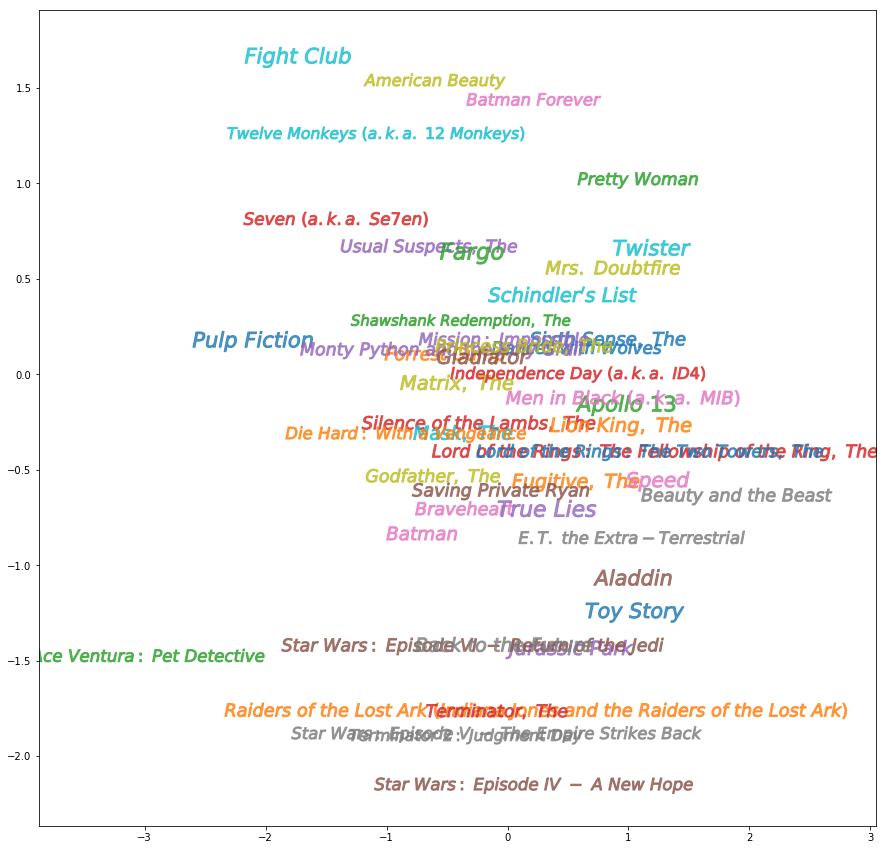

In [44]:
plt.figure(figsize=(15,15))
markers = ["$ {} $".format("\ ".join(m.split(" ")[:-1])) for m in top["movie_title"][:50]]
for i,item in enumerate(factors[:50,:]):
    l = len(markers[i])
    plt.scatter(item[0], item[1], marker = markers[i], alpha=0.75, s = 50 * (l**2))
plt.show()

And here are the other two:

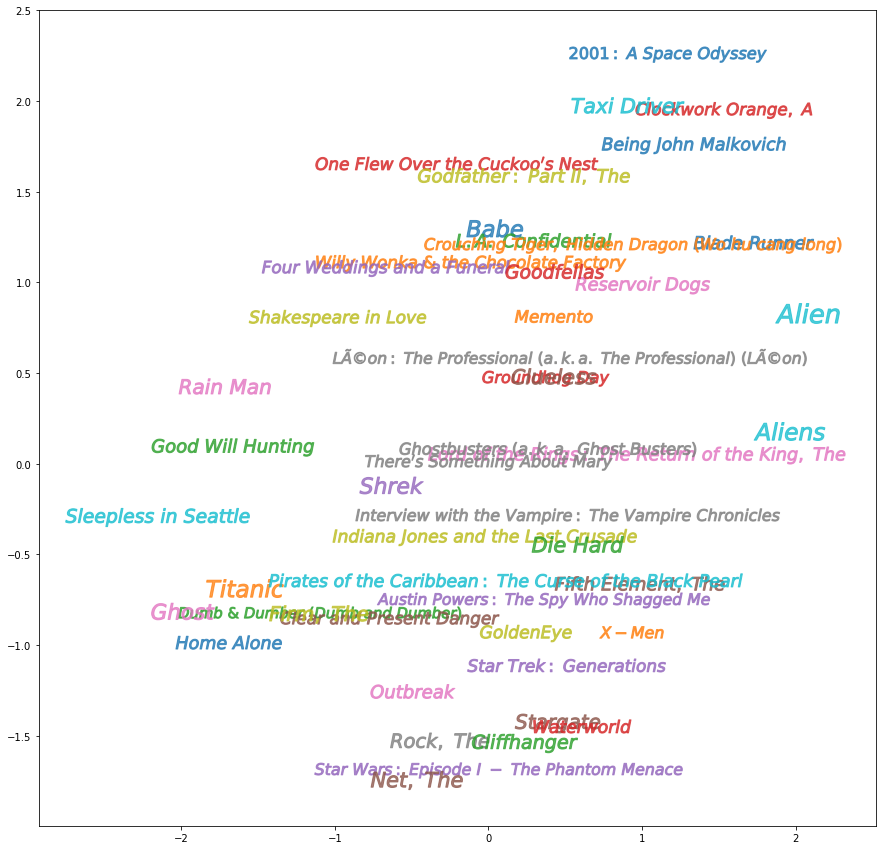

In [45]:
plt.figure(figsize=(15,15))
markers = ["$ {} $".format("\ ".join(m.split(" ")[:-1])) for m in top["movie_title"][50:]]
for i,item in enumerate(factors[50:,:]):
    l = len(markers[i])
    plt.scatter(item[2], item[3], marker = markers[i], alpha=0.75, s = 50 * (l**2))
plt.show()

Below is another way of visualizing. Neither the code nor the result are very pretty, but it divides the entire latent space into a 2D grid, identifies the top few movies (ranked by number of ratings) in each grid square, and prints the resultant grid.

In [79]:
def clean_title(s):
    remove = [", The", ", A", ", An"]
    s1 = " ".join(s.split(" ")[:-1])
    for suffix in remove:
        if s1.endswith(suffix):
            s1 = s1[:-len(suffix)]
    return s1

sorted_num_rating = np.array(np.argsort(movie_stats.sort_values("num_ratings", ascending=False).num_ratings))
sorted_num_rating = sorted_num_rating[sorted_num_rating >= 0]
def latent_factor_grid(latent_space, count=2):
    factors = svd4.q[:2,sorted_num_rating]
    # We've already set stdev in all dimensions to 1, so a multiple of it is okay:
    bin_vals = np.arange(-2, 2, 1/4)
    bins = np.digitize(latent_space, bin_vals).T
    #bins
    # Now: What is the first instance of each bin in each axis?
    # (May make most sense if sorted first by # of ratings)
    n = len(bin_vals)
    first_idxs = np.zeros((n,n), dtype=np.int32)
    first_titles = np.zeros((n,n), dtype=np.object)
    for i in range(n):
        for j in range(n):
            # where is first occurence of bin (i,j)?
            matches = (bins == [i,j]).prod(axis=1)
            first = np.nonzero(matches)[0]
            first_titles[i,j] = ""
            if first.size > 0:
                first_idxs[i,j] = first[0]
                if first[0] > 0:
                    # Could easily modify this to get the 2nd, 3rd, etc.
                    # item of these bins
                    first_titles[i,j] = "; ".join(
                        [clean_title(movie_stats.loc[first[i]].movie_title)
                         for i in range(0,min(count,len(first)))
                         if first[i] in movie_stats.index]
                    )
                    # that final check is needed because (I think)
                    # my SVD matrices are randomly-initialized, and
                    # movie indices with no data (not all IDs are used)
                    # are never updated
            else:
                first_idxs[i,j] = -1
    return pd.DataFrame(first_titles)

In [80]:
pd.set_option('display.max_rows', 500)
latent_factor_grid(svd4.q[:2,:])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,,,,,,,,,,,,,,
1,,,,,Dumb & Dumber (Dumb and Dumber),,,,,,,,,,,
2,,,,,,,,,,,,,,,,
3,,,,,,Tommy Boy; Ace Ventura: Pet Detective,,Ace Ventura: When Nature Calls; Billy Madison,BASEketball,Half Baked,,Natural Born Killers; Fear and Loathing in Las...,,,,
4,,,,,,Beavis and Butt-Head Do America,Happy Gilmore,Spaceballs; Eddie Murphy Raw,,Don't Be a Menace to South Central While Drink...,National Lampoon's Senior Trip; Event Horizon,Four Rooms; Where the Buffalo Roam,,Julien Donkey-Boy,,
5,,,,,Austin Powers: International Man of Mystery,Fletch; Rambo: First Blood Part II,Kingpin; Jerk,Friday; Pulp Fiction,Casino; Clerks,From Dusk Till Dawn; Faster Pussycat! Kill! Kill!,Bio-Dome; In the Mouth of Madness,Switchblade Sisters; Stardust Memories,Cook the Thief His Wife & Her Lover; Lost Highway,Even Cowgirls Get the Blues,,
6,,,,,Animal House; Caddyshack,Conan the Barbarian; First Blood (Rambo: First...,Goodfellas; Evil Dead II (Dead by Dawn),Dazed and Confused; Mystery Science Theater 30...,Heat; Seven (a.k.a. Se7en),Leaving Las Vegas; Heidi Fleiss: Hollywood Madam,Dead Presidents; Things to Do in Denver When Y...,Dracula: Dead and Loving It; Canadian Bacon,Being Human; Road to Wellville,Doom Generation; Boxing Helena,,
7,,,,,Rocky; Airplane!,There's Something About Mary; American Pie,Die Hard: With a Vengeance; Batman,So I Married an Axe Murderer; Tombstone,Grumpier Old Men; Usual Suspects,Nixon; Twelve Monkeys (a.k.a. 12 Monkeys),Shanghai Triad (Yao a yao yao dao waipo qiao);...,"Hate (Haine, La); Basketball Diaries",If Lucy Fell; Jade,Ready to Wear (Pret-A-Porter); Pillow Book,,
8,,,,,Terminator 2: Judgment Day; Die Hard,Aliens; Star Wars: Episode VI - Return of the ...,Braveheart; Mask,GoldenEye; Shawshank Redemption,,Guardian Angel,Money Train; Assassins,When Night Is Falling; Two if by Sea,Carrington; Antonia's Line (Antonia),Tank Girl; Eye of the Beholder,,
9,,,,Jaws,Star Wars: Episode IV - A New Hope; Raiders of...,Nutty Professor; Back to the Future,True Lies; Home Alone,Crimson Tide; Clear and Present Danger,Get Shorty; Across the Sea of Time,Sudden Death; Wings of Courage,Tom and Huck; Richard III,Powder; Now and Then,Home for the Holidays; Lawnmower Man 2: Beyond...,Priest; But I'm a Cheerleader,,


Both axes seem to start more on the low-brow side along the top left.  There is come clear clustering around certain themes but it's hard to put clearly to words. The fact that *Rocky* and *Airplane!* landed in the same grid square, as did *Apollo 13* and *Santa Clause*, is interesting.

Here is the same thing for the other two dimensions in this latent space:

In [81]:
latent_factor_grid(svd4.q[2:,:])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,
4,,,,,,Patch Adams,,Music of the Heart; Love Story,Steel Magnolias,,Bridges of Madison County; Sound of Music,,,,,
5,,,,,First Knight,Pay It Forward,Father of the Bride Part II; Up Close and Pers...,Legends of the Fall; Love Affair,Pocahontas; Mr. Holland's Opus,Philadelphia; Dances with Wolves,Cinderella; Fried Green Tomatoes,Out of Africa,,,,
6,,,,Big Momma's House 2,D3: The Mighty Ducks; Here on Earth,Big Green; Free Willy 2: The Adventure Home,Grumpier Old Men; Dangerous Minds,Sabrina; American President,How to Make an American Quilt; Far From Home: ...,Lion King; Aladdin,"MisÃ©rables, Les; Circle of Friends",Snow White and the Seven Dwarfs; Pinocchio,,,,
7,,,,Armageddon; Police Academy 4: Citizens on Patrol,Jury Duty; Major Payne,Ace Ventura: When Nature Calls; It Takes Two,Tom and Huck; Dunston Checks In,Powder; Now and Then,Waiting to Exhale; Balto,Indian in the Cupboard; Birdcage,Beautiful Girls; Brothers McMullen,Antonia's Line (Antonia); Like Water for Choco...,"Sense and Sensibility; Postman, The (Postino, Il)",Hamlet; Civil War,,
8,,,Transformers: Revenge of the Fallen,"2 Fast 2 Furious (Fast and the Furious 2, The)...",Bio-Dome; Beverly Hills Cop III,Money Train; Assassins,Jumanji; Race the Sun,Copycat; Kids of the Round Table,Across the Sea of Time; City Hall,Heat; Restoration,Toy Story; Othello,Persuasion; Dead Man Walking,Anne Frank Remembered; Boys of St. Vincent,Bread and Chocolate (Pane e cioccolata); Stree...,,
9,,,,Tomcats; Deuce Bigalow: European Gigolo,Cutthroat Island; Fair Game,Sudden Death; Dracula: Dead and Loving It,GoldenEye; Two if by Sea,Nick of Time; Mallrats,Four Rooms; Wings of Courage,,Casino; Clueless,Nixon; Babe,Bottle Rocket; Nobody Loves Me (Keiner liebt m...,Leaving Las Vegas; Hoop Dreams,"World of Apu, The (Apur Sansar); 400 Blows, Th...",


Some sensible axes seem to form here too. Moving from left to right (i.e. increasing horizontal axis) seems to go from movies with 'simpler' themes (I'm not really sure of the right term) to movies that are a bit more cryptic and enigmatic.  Moving from the top to bottom (i.e. increasing vertical axis) seems to go from more lighthearted and uplifting movies, to more violent movies, all the way to horror movies.

## 6.8. Bias

We can also look at the per-movie bias parameters in the model - loosely, how much higher or lower a movie's rating is, beyond what interactions with user preferences seem to explain. Here are the top 10 and bottom 10; interestingly, while to seems to correlate with the average rating, it doesn't seem to do so especially strongly.

In [62]:
#bias = movie_stats.assign(bias = svd40.b_i[:-1]).sort_values("bias", ascending=False)
bias = movie_stats.join(pd.Series(svd40.b_i[:-1]).rename("bias")).sort_values("bias", ascending=False).dropna()
bias.iloc[:10]

,movie_title,num_ratings,avg_rating,bias
movie_id,,,,
318,"Shawshank Redemption, The (1994)",63366.0,4.446990,1.015911
100553,Frozen Planet (2011),31.0,4.209677,1.010655
858,"Godfather, The (1972)",41355.0,4.364732,0.978110
105250,"Century of the Self, The (2002)",43.0,3.930233,0.956971
93040,"Civil War, The (1990)",256.0,4.113281,0.941702
7502,Band of Brothers (2001),4305.0,4.263182,0.926048
77658,Cosmos (1980),936.0,4.220620,0.916784
50,"Usual Suspects, The (1995)",47006.0,4.334372,0.910651
102217,Bill Hicks: Revelations (1993),50.0,3.990000,0.900622


In [63]:
bias.iloc[:-10:-1]

,movie_title,num_ratings,avg_rating,bias
movie_id,,,,
8859,SuperBabies: Baby Geniuses 2 (2004),209.0,0.837321,-2.377202
54290,Bratz: The Movie (2007),180.0,1.105556,-2.248130
6483,From Justin to Kelly (2003),426.0,0.973005,-2.214592
61348,Disaster Movie (2008),397.0,1.251889,-2.131157
6371,PokÃ©mon Heroes (2003),325.0,1.167692,-2.061165
1826,Barney's Great Adventure (1998),419.0,1.163484,-2.051037
4775,Glitter (2001),685.0,1.124088,-2.047287
31698,Son of the Mask (2005),467.0,1.252677,-2.022763
5739,Faces of Death 6 (1996),174.0,1.261494,-2.004086


# 7. Implementations in `scikit-surprise`

[Surprise](http://surpriselib.com/) contains implementations of many of the same things, so these are tested below. This same dataset is included as a built-in, but for consistency, we may as well load it from our dataframe.

Results below are cross-validated, while our results above aren't, so comparison may have some noise to it (i.e. if you change the random seed you may see our results perform much better or worse while the Surprise results should be more consistent).

In [ ]:
import surprise
from surprise.dataset import Dataset

Note the `.iloc[::10]` below, which is a quick way to decimate the data by a factor of 10. Surprise seems to be less memory-efficient than my code above (at least, without any tuning whatsoever), so in order to test it I don't pass in the entire dataset.

In [74]:
reader = surprise.Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ml[["user_id", "movie_id", "rating"]].iloc[::10], reader)
cv=5
cv_random = surprise.model_selection.cross_validate(surprise.NormalPredictor(), data, cv=cv)
cv_sl1 = surprise.model_selection.cross_validate(surprise.SlopeOne(), data, cv=cv)
cv_svd = surprise.model_selection.cross_validate(surprise.SVD(), data, cv=cv)

# 8. Overall results

In [78]:
get_record = lambda name, df: \
    ("Surprise", name, df["test_mae"].sum() / cv, df["test_rmse"].sum() / cv)
cv_data_surprise = [
    get_record(name,d) for name,d in [("Random", cv_random), ("Slope One", cv_sl1), ("SVD", cv_svd)]
]
pd.DataFrame.from_records(
    data=test_results + cv_data_surprise,
    columns=("Library", "Algorithm", "MAE (test)", "RMSE (test)"),
)

,Library,Algorithm,MAE (test),RMSE (test)
0,,Slope One,0.656514,0.856294
1,,SVD,0.600111,0.787375
2,Surprise,Random,1.144775,1.433753
3,Surprise,Slope One,0.704730,0.923331
4,Surprise,SVD,0.694890,0.900350


# 9. Further Work

All of the code in the notebook above is fairly raw and unoptimized. One could likely produce much better performance with a lower-level and multithreaded implementation, with more optimized matrix routines (perhaps GPU-optimized) with something like [Numba](https://numba.pydata.org/), or with a distributed implementation in something like [Dask](https://dask.pydata.org/en/latest/) or Spark.

Within recommender systems, this post covered only collaborative filtering. A part 2 post will follow which covers *content-based filtering*, another broad category of recommender systems.